/tmp/ipython-input-1804203165.py:389: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


Training Enhanced DQN with Safety Constraints...


/tmp/ipython-input-1804203165.py:247: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([e[0] for e in batch]).to(self.device)


Episode 0, Avg Score: 272.70, Avg Glucose: 133.45, Safety Issues: 23.00
Episode 50, Avg Score: 312.18, Avg Glucose: 133.45, Safety Issues: 17.28
Episode 100, Avg Score: 308.12, Avg Glucose: 133.45, Safety Issues: 19.36
Episode 150, Avg Score: 203.70, Avg Glucose: 133.45, Safety Issues: 23.64
Episode 200, Avg Score: 365.68, Avg Glucose: 133.45, Safety Issues: 18.32
Episode 250, Avg Score: 339.78, Avg Glucose: 133.45, Safety Issues: 17.48
Episode 300, Avg Score: 127.92, Avg Glucose: 133.45, Safety Issues: 21.84
Episode 350, Avg Score: 62.14, Avg Glucose: 133.45, Safety Issues: 24.22
Episode 400, Avg Score: 139.00, Avg Glucose: 133.45, Safety Issues: 19.42
Episode 450, Avg Score: 188.16, Avg Glucose: 133.45, Safety Issues: 18.62
Analyzing learned policy...
Policy Safety: 96.2% of recommendations are safe

Safe Recommendations Sample (3910 total):
            timestamp  current_glucose basal_action bolus_action carb_action  \
0 2018-06-13 19:40:00            255.0       Adjust          Yes

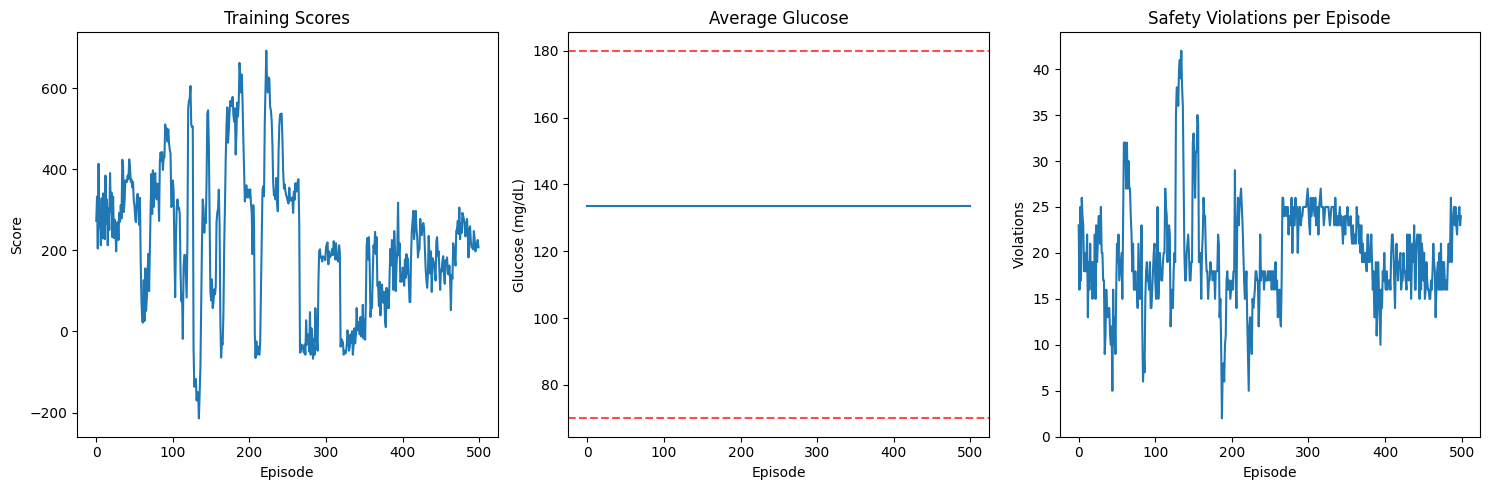

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

class ImprovedDiabetesEnvironment:
    def __init__(self, data, lookback=12, prediction_horizon=6):
        self.data = data.reset_index(drop=True)
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.current_step = lookback
        self.max_steps = len(data) - lookback - prediction_horizon

        # Safer action space
        self.n_actions = 8  # Reduced complexity: 2 basal × 2 bolus × 2 carb actions

        # Enhanced state representation
        self.state_size = lookback * 6  # Key features only

        # Medical safety parameters
        self.target_min = 70
        self.target_max = 180
        self.critical_low = 55
        self.critical_high = 250

    def get_state_representation(self, step):
        """Enhanced state representation with clinical features"""
        start_idx = step - self.lookback
        end_idx = step

        state_data = self.data.iloc[start_idx:end_idx]

        state = []
        for i in range(len(state_data)):
            row = state_data.iloc[i]

            # Core clinical features
            glucose_norm = row['glucose'] / 400.0
            hr_norm = row['heart_rate'] / 200.0
            steps_norm = min(row['steps'] / 100.0, 1.0)  # Cap at 1.0
            basal_norm = row['basal_rate'] / 0.15

            # Derived clinical features
            if i > 0:
                prev_glucose = state_data.iloc[i-1]['glucose']
                glucose_trend = (row['glucose'] - prev_glucose) / 20.0  # More sensitive trend
                glucose_trend = np.clip(glucose_trend, -2, 2)  # Bound trends
            else:
                glucose_trend = 0

            # Risk indicator
            glucose_risk = 0
            if row['glucose'] < 70: glucose_risk = -1
            elif row['glucose'] > 180: glucose_risk = 1

            state.extend([glucose_norm, hr_norm, steps_norm, basal_norm,
                         glucose_trend, glucose_risk])

        return np.array(state)

    def decode_action(self, action):
        """Simplified action decoding with safety"""
        basal_action = (action // 4) % 2  # 0=maintain, 1=adjust
        bolus_action = (action // 2) % 2  # 0=no, 1=yes
        carb_action = action % 2          # 0=no, 1=yes

        return basal_action, bolus_action, carb_action

    def step(self, action):
        current_data = self.data.iloc[self.current_step]
        current_glucose = current_data['glucose']

        basal_action, bolus_action, carb_action = self.decode_action(action)

        # Look ahead for future glucose
        future_step = min(self.current_step + self.prediction_horizon, len(self.data) - 1)
        future_glucose = self.data.iloc[future_step]['glucose']

        # Enhanced reward with safety constraints
        reward = self.calculate_safe_reward(current_glucose, future_glucose,
                                          basal_action, bolus_action, carb_action,
                                          current_data)

        self.current_step += 1
        done = self.current_step >= self.max_steps

        next_state = self.get_state_representation(self.current_step) if not done else None

        return next_state, reward, done, {
            'current_glucose': current_glucose,
            'future_glucose': future_glucose,
            'basal_action': basal_action,
            'bolus_action': bolus_action,
            'carb_action': carb_action
        }

    def calculate_safe_reward(self, current_glucose, future_glucose,
                            basal_action, bolus_action, carb_action, current_data):
        """Enhanced reward function with medical safety"""
        reward = 0

        # Primary glucose target reward (shaped)
        if self.target_min <= future_glucose <= self.target_max:
            reward += 10
        else:
            # Distance-based penalty
            if future_glucose < self.target_min:
                distance = self.target_min - future_glucose
                reward -= distance * 0.5
            else:
                distance = future_glucose - self.target_max
                reward -= distance * 0.2

        # Critical safety penalties
        if future_glucose < self.critical_low:
            reward -= 25
        if future_glucose > self.critical_high:
            reward -= 20

        # Action safety constraints
        if current_glucose < 80 and bolus_action == 1:  # Bolus when low
            reward -= 15
        if current_glucose > 200 and carb_action == 1:  # Carbs when high
            reward -= 10
        if current_glucose < 70 and basal_action == 1:  # Adjust basal when low
            reward -= 10

        # Stability reward
        glucose_change = abs(future_glucose - current_glucose)
        if glucose_change < 15:
            reward += 3
        elif glucose_change > 60:
            reward -= 5

        # Activity-aware rewards
        if current_data['steps'] > 50:  # During activity
            if bolus_action == 1:  # Penalize bolus during activity
                reward -= 3
            if carb_action == 1:  # Reward carbs during activity if glucose trending down
                if current_glucose < 120:
                    reward += 2

        return reward

    def reset(self):
        self.current_step = self.lookback
        return self.get_state_representation(self.current_step)

class EnhancedDQNAgent:
    def __init__(self, state_size, action_size, k_neighbors=50, memory_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.k_neighbors = k_neighbors
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005  # Lower learning rate for stability
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Dual network for stability (DDQN)
        self.model = self._build_model().to(self.device)
        self.target_model = self._build_model().to(self.device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.SmoothL1Loss()  # Huber loss for stability

        # For k-NN experience selection
        self.nearest_neighbors = None
        self.state_memory = []

    def _build_model(self):
        """Enhanced network architecture"""
        return nn.Sequential(
            nn.Linear(self.state_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )

    def update_target_model(self):
        """Update target network weights"""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Store experience with state for k-NN lookup"""
        self.memory.append((state, action, reward, next_state, done))
        self.state_memory.append(state)

    def build_knn_index(self):
        """Build k-NN index for similar experience selection"""
        if len(self.state_memory) > self.k_neighbors:
            self.nearest_neighbors = NearestNeighbors(n_neighbors=self.k_neighbors, metric='euclidean')
            self.nearest_neighbors.fit(np.array(self.state_memory))

    def act(self, state, training=True):
        """Enhanced action selection with exploration"""
        if training and np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return np.argmax(q_values.cpu().data.numpy())

    def replay(self):
        """Enhanced experience replay with k-NN sampling"""
        if len(self.memory) < self.batch_size:
            return

        # Build k-NN index if needed
        if self.nearest_neighbors is None and len(self.state_memory) > self.k_neighbors:
            self.build_knn_index()

        if self.nearest_neighbors is not None:
            # Sample recent state as query
            query_state = random.choice(self.state_memory[-100:])  # Recent states
            query_state = np.array(query_state).reshape(1, -1)

            # Find similar experiences
            try:
                _, indices = self.nearest_neighbors.kneighbors(query_state)
                # Sample from similar experiences
                batch_indices = random.sample(list(indices[0]), min(self.batch_size, len(indices[0])))
                batch = [self.memory[i] for i in batch_indices if i < len(self.memory)]
            except:
                # Fallback to random sampling
                batch = random.sample(self.memory, self.batch_size)
        else:
            # Random sampling until k-NN is ready
            batch = random.sample(self.memory, self.batch_size)

        # Prepare batch data
        states = torch.FloatTensor([e[0] for e in batch]).to(self.device)
        actions = torch.LongTensor([e[1] for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e[2] for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e[3] for e in batch]).to(self.device)
        dones = torch.BoolTensor([e[4] for e in batch]).to(self.device)

        # Double DQN update
        current_q = self.model(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = self.model(next_states).max(1)[1]
            next_q = self.target_model(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (self.gamma * next_q * ~dones)

        loss = self.criterion(current_q.squeeze(), target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_enhanced_dqn(data, episodes=1000, lookback=12):
    """Enhanced training with the improved algorithm"""
    env = ImprovedDiabetesEnvironment(data, lookback=lookback)
    agent = EnhancedDQNAgent(env.state_size, env.n_actions)

    scores = []
    glucose_levels = []
    safety_violations = []

    target_update_freq = 10  # Update target network every 10 episodes

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_glucose = []
        safety_issues = 0

        for step in range(200):  # Limit steps per episode
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # Track safety violations
            current_glucose = info['current_glucose']
            if (current_glucose < 70 and info['bolus_action'] == 1) or \
               (current_glucose > 200 and info['carb_action'] == 1):
                safety_issues += 1

            if next_state is not None:
                agent.remember(state, action, reward, next_state, done)

            total_reward += reward
            episode_glucose.append(current_glucose)
            state = next_state

            if done:
                break

        # Train more frequently
        for _ in range(3):
            agent.replay()

        # Update target network
        if episode % target_update_freq == 0:
            agent.update_target_model()

        scores.append(total_reward)
        glucose_levels.append(np.mean(episode_glucose))
        safety_violations.append(safety_issues)

        if episode % 50 == 0:
            avg_score = np.mean(scores[-50:]) if len(scores) >= 50 else np.mean(scores)
            avg_glucose = np.mean(glucose_levels[-50:]) if len(glucose_levels) >= 50 else np.mean(glucose_levels)
            avg_safety = np.mean(safety_violations[-50:]) if len(safety_violations) >= 50 else np.mean(safety_violations)
            print(f"Episode {episode}, Avg Score: {avg_score:.2f}, Avg Glucose: {avg_glucose:.2f}, Safety Issues: {avg_safety:.2f}")

    return agent, scores, glucose_levels, safety_violations

def safe_policy_analysis(agent, data, lookback=12):
    """Analyze the learned policy with safety checks"""
    env = ImprovedDiabetesEnvironment(data, lookback=lookback)
    state = env.reset()

    recommendations = []
    safety_checks = []

    while True:
        action = agent.act(state, training=False)  # No exploration during evaluation
        basal_action, bolus_action, carb_action = env.decode_action(action)

        current_data = data.iloc[env.current_step]
        current_glucose = current_data['glucose']

        # Safety validation
        safety_ok = True
        safety_notes = []

        if current_glucose < 80 and bolus_action == 1:
            safety_ok = False
            safety_notes.append("Bolus recommended during low glucose")
        if current_glucose > 200 and carb_action == 1:
            safety_ok = False
            safety_notes.append("Carbs recommended during high glucose")
        if current_glucose < 70 and basal_action == 1:
            safety_ok = False
            safety_notes.append("Basal adjustment during hypoglycemia")

        recommendation = {
            'timestamp': current_data['time'],
            'current_glucose': current_glucose,
            'basal_action': 'Adjust' if basal_action == 1 else 'Maintain',
            'bolus_action': 'Yes' if bolus_action == 1 else 'No',
            'carb_action': 'Yes' if carb_action == 1 else 'No',
            'safety_ok': safety_ok,
            'safety_notes': '; '.join(safety_notes) if safety_notes else 'Safe',
            'heart_rate': current_data['heart_rate'],
            'steps': current_data['steps']
        }

        recommendations.append(recommendation)
        safety_checks.append(safety_ok)

        next_state, _, done, _ = env.step(action)
        if done or next_state is None:
            break
        state = next_state

    safety_percentage = (sum(safety_checks) / len(safety_checks)) * 100
    print(f"Policy Safety: {safety_percentage:.1f}% of recommendations are safe")

    return pd.DataFrame(recommendations)

# Load and run
def load_data():
    df = pd.read_csv("HUPA0001P.csv", sep=';')
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    df = df.fillna(method='ffill').fillna(0)
    return df

if __name__ == "__main__":
    data = load_data()

    print("Training Enhanced DQN with Safety Constraints...")
    agent, scores, glucose_levels, safety_violations = train_enhanced_dqn(data, episodes=500, lookback=12)

    print("Analyzing learned policy...")
    recommendations = safe_policy_analysis(agent, data)

    # Display safe recommendations
    safe_recommendations = recommendations[recommendations['safety_ok'] == True]
    print(f"\nSafe Recommendations Sample ({len(safe_recommendations)} total):")
    print(safe_recommendations.head(10))

    # Plot results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(scores)
    plt.title('Training Scores')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(glucose_levels)
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.7)
    plt.axhline(y=180, color='r', linestyle='--', alpha=0.7)
    plt.title('Average Glucose')
    plt.xlabel('Episode')
    plt.ylabel('Glucose (mg/dL)')

    plt.subplot(1, 3, 3)
    plt.plot(safety_violations)
    plt.title('Safety Violations per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Violations')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

df['glucose_diff'] = df['glucose'].diff().abs()
corr_bolus = df['glucose_diff'].corr(df['bolus_volume_delivered'])
corr_carb = df['glucose_diff'].corr(df['carb_input'])

print("Correlation with bolus:", corr_bolus)
print("Correlation with carb:", corr_carb)


Correlation with bolus: 0.00786958271389934
Correlation with carb: 0.0029294117920845007
